In [1]:
from scripts.geometry_corrector import GeometryCorrector
from scripts.shrink_volume import VolumeShrinker
from cil.io.utilities import HDF5_utilities
from cil.framework import AcquisitionData, AcquisitionGeometry
from cil.processors import TransmissionAbsorptionConverter, Normaliser
from cil.utilities.display import show2D, show_geometry
from cil.plugins.astra.processors import FBP
from cil.io import TIFFWriter

import numpy as np
from scipy.spatial.transform import Rotation as R
import os


/home/bgb37495/miniconda3/envs/lamino_small/lib/python3.12/site-packages/dxchange/__init__.py:63: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
file_path = "/mnt/share/ALC_laminography/folder/k11-54286.nxs"
detector_pixel_size=0.54 # um - get this from the file in future
cor = 0 # pix
tilt = 35 # deg

optimise_geometry = True
cor_bounds = (-20, 20) # pixels
tilt_bounds = (30, 40) # deg
tilt_tol = 0.01 # deg
cor_tol = 0.01 # pixels

In [3]:
image_key = HDF5_utilities.read(file_path, '/entry/instrument/EtherCAT/image_key')

unique_keys, counts = np.unique(image_key, return_counts=True)
for key, count in zip(unique_keys, counts):
    key_type = {0: "Tomography", 1: "Flat field", 2: "Dark field"}.get(key, f"Unknown ({key})")
    print(f"  {key_type} images: {count}")

data = HDF5_utilities.read(filename=file_path, dset_path='/entry/imaging/data', source_sel=(image_key == 0,))
flat = HDF5_utilities.read(filename=file_path, dset_path='/entry/imaging/data', source_sel=(image_key == 1,))
dark = HDF5_utilities.read(filename=file_path, dset_path='/entry/imaging/data', source_sel=(image_key == 2,))

angles = HDF5_utilities.read(file_path, '/entry/imaging_sum/smaract_zrot')
pixel_size_x = detector_pixel_size
pixel_size_y = detector_pixel_size


  Tomography images: 1441
  Flat field images: 20
  Dark field images: 20


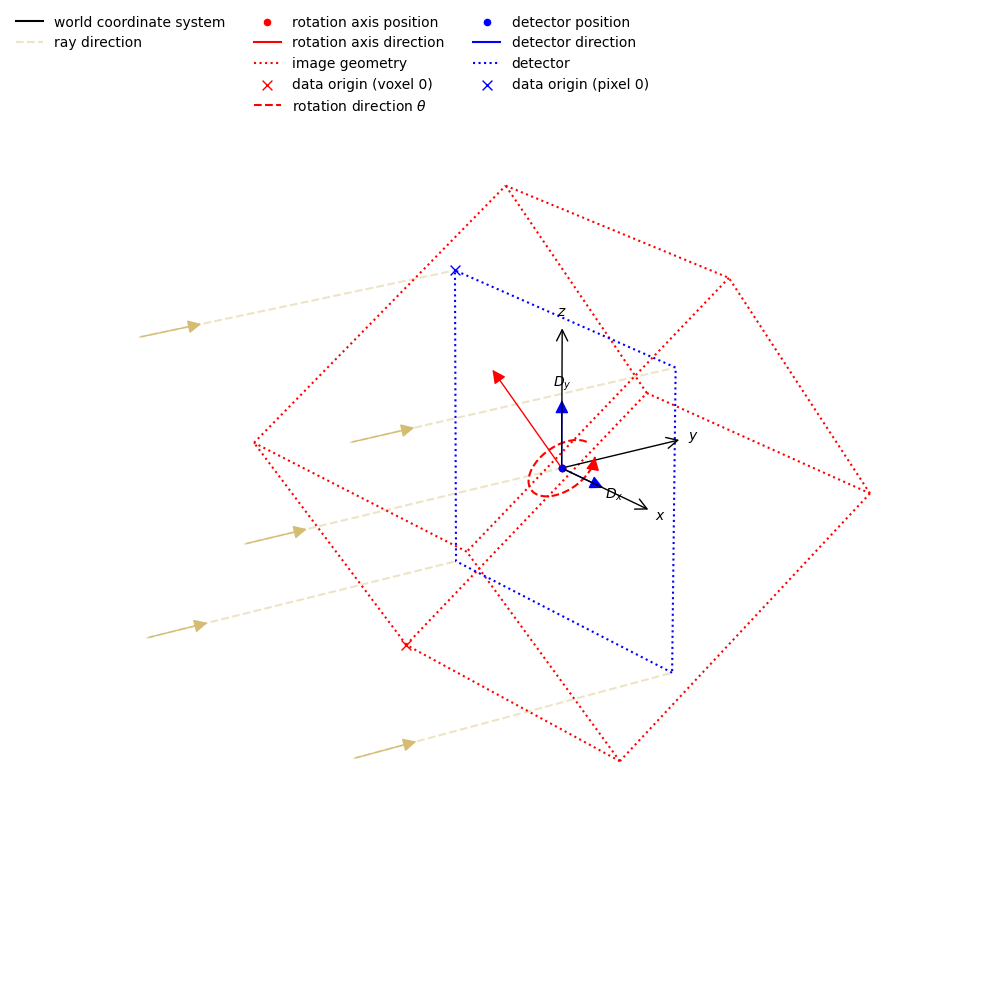

In [4]:
tilt_direction_vector=np.array([1, 0, 0])
original_rotation_axis=np.array([0, 0, 1])

rotation_matrix = R.from_rotvec(np.deg2rad(tilt) * tilt_direction_vector)
tilted_rotation_axis = rotation_matrix.apply(original_rotation_axis)

ag = AcquisitionGeometry.create_Parallel3D(rotation_axis_direction=tilted_rotation_axis)
ag.set_angles(angles[image_key==0,])
ag.set_panel([data.shape[2], data.shape[1]],
             pixel_size = (pixel_size_x, pixel_size_y),
             origin='top-left')

ag.set_centre_of_rotation(offset=cor, distance_units='pixels')


ag.config.system.rotation_axis.direction = tilted_rotation_axis

show_geometry(ag)

data = AcquisitionData(data, geometry=ag)

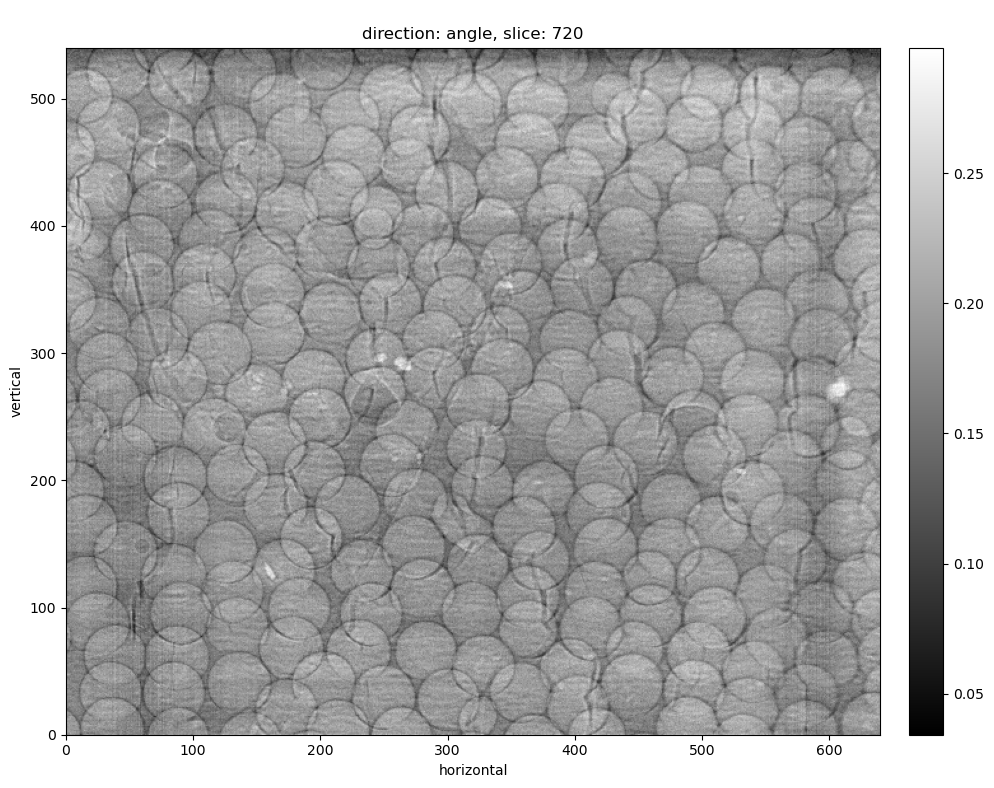

In [5]:
data = Normaliser(np.mean(flat, axis=0), np.mean(dark, axis=0))(data)
data = TransmissionAbsorptionConverter(min_intensity=1e-6)(data)
show2D(data)

In [6]:
data.reorder('astra')
print(data.dimension_labels)

(<AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)


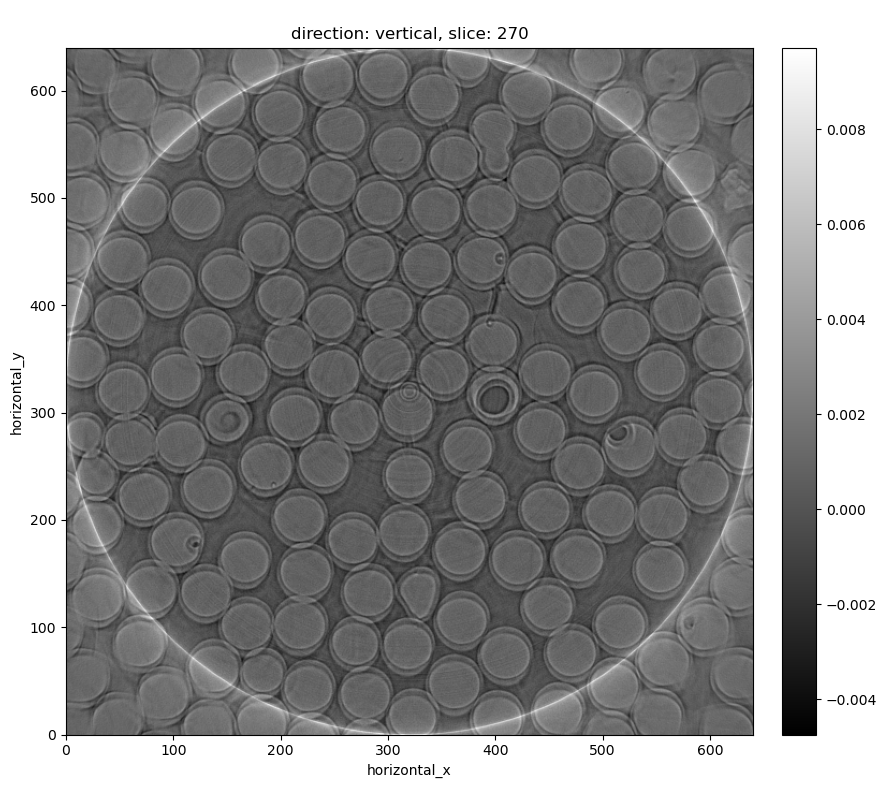

In [7]:
ag = data.geometry
ig = ag.get_ImageGeometry()

fbp = FBP(ig, ag)
recon = fbp(data)
show2D(recon)

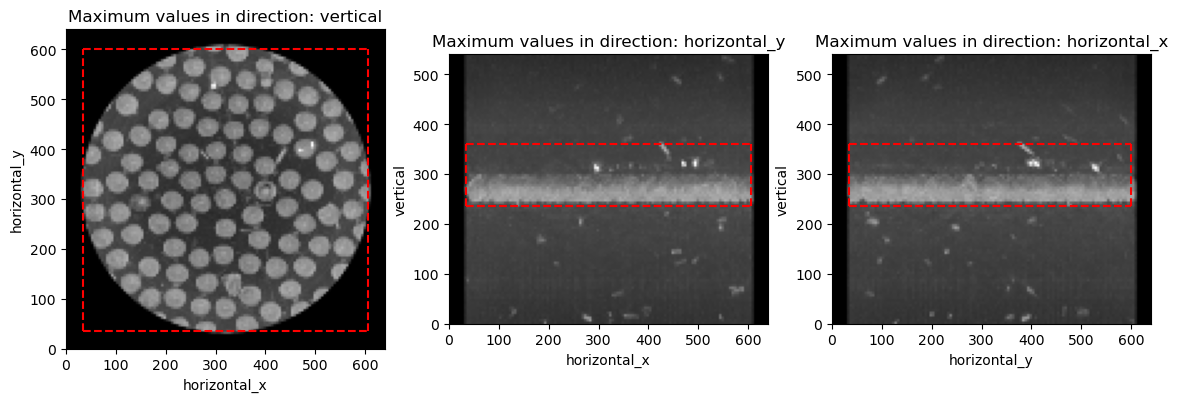

In [8]:
if optimise_geometry:
    vs = VolumeShrinker()
    ig = vs.run(data, auto=True)

Tilt bounds : (30.000:40.000), CoR bounds : (-20.000:20.000)
tilt: 35.000, CoR: 0.000, loss: 4.019e+04
tilt: 33.820, CoR: 0.000, loss: 3.998e+04
tilt: 36.180, CoR: 0.000, loss: 4.020e+04
tilt: 32.361, CoR: 0.000, loss: 4.023e+04
tilt: 34.327, CoR: 0.000, loss: 4.007e+04
tilt: 33.262, CoR: 0.000, loss: 3.999e+04
tilt: 33.573, CoR: 0.000, loss: 3.997e+04
tilt: 33.566, CoR: 0.000, loss: 3.997e+04
tilt: 33.601, CoR: 0.000, loss: 3.997e+04
tilt: 33.583, CoR: 0.000, loss: 3.997e+04
tilt: 33.580, CoR: 0.000, loss: 3.997e+04
tilt: 33.590, CoR: 0.000, loss: 3.997e+04
tilt: 33.594, CoR: 0.000, loss: 3.997e+04
tilt: 33.590, CoR: -4.721, loss: 4.135e+04
tilt: 33.590, CoR: 4.721, loss: 3.881e+04
tilt: 33.590, CoR: 10.557, loss: 4.124e+04
tilt: 33.590, CoR: 2.995, loss: 3.701e+04
tilt: 33.590, CoR: 0.048, loss: 3.991e+04
tilt: 33.590, CoR: 2.657, loss: 3.703e+04
tilt: 33.590, CoR: 2.862, loss: 3.700e+04
tilt: 33.590, CoR: 2.852, loss: 3.700e+04
tilt: 33.590, CoR: 2.842, loss: 3.700e+04
tilt: 32.180,

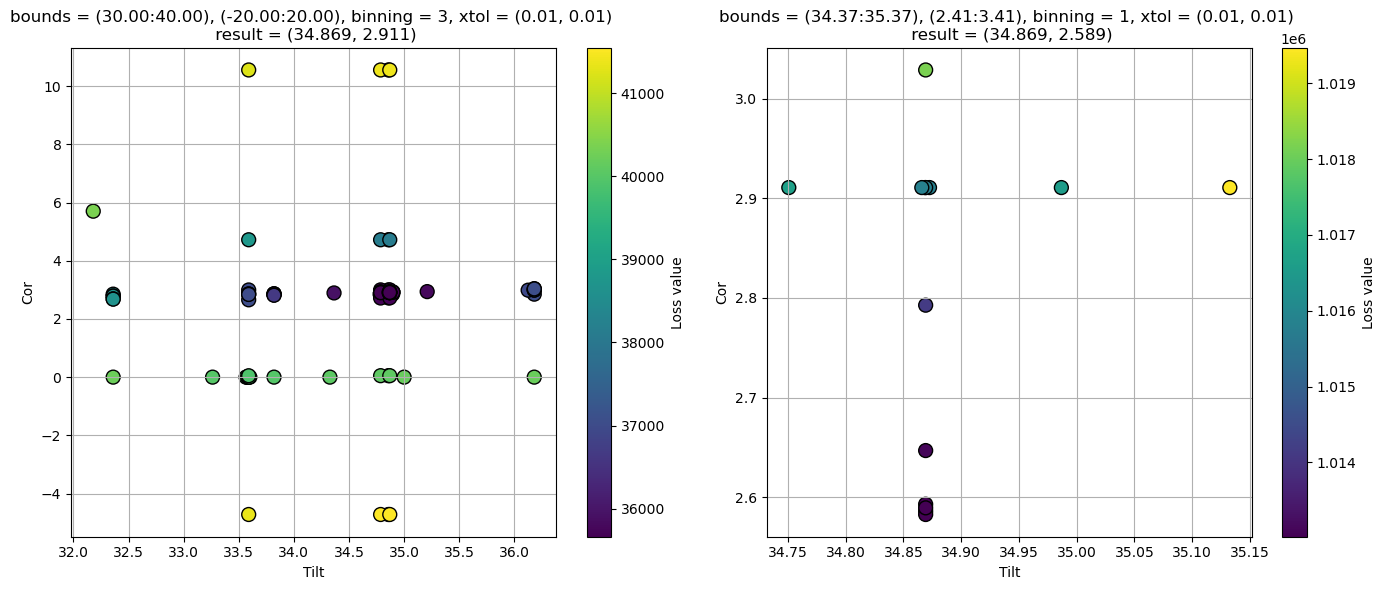

In [9]:
if optimise_geometry:

    if data.get_dimension_size('horizontal') > 1280:
        final_binning = 2
    else:
        final_binning = None
    
    processor = GeometryCorrector(initial_parameters=(tilt, cor), parameter_bounds=(tilt_bounds, cor_bounds), parameter_tolerance=(tilt_tol, cor_tol),
                                  final_binning=final_binning, reduced_volume=ig)

    processor.set_input(data)
    data_corrected = processor.get_output()

    processor.plot_evaluations()

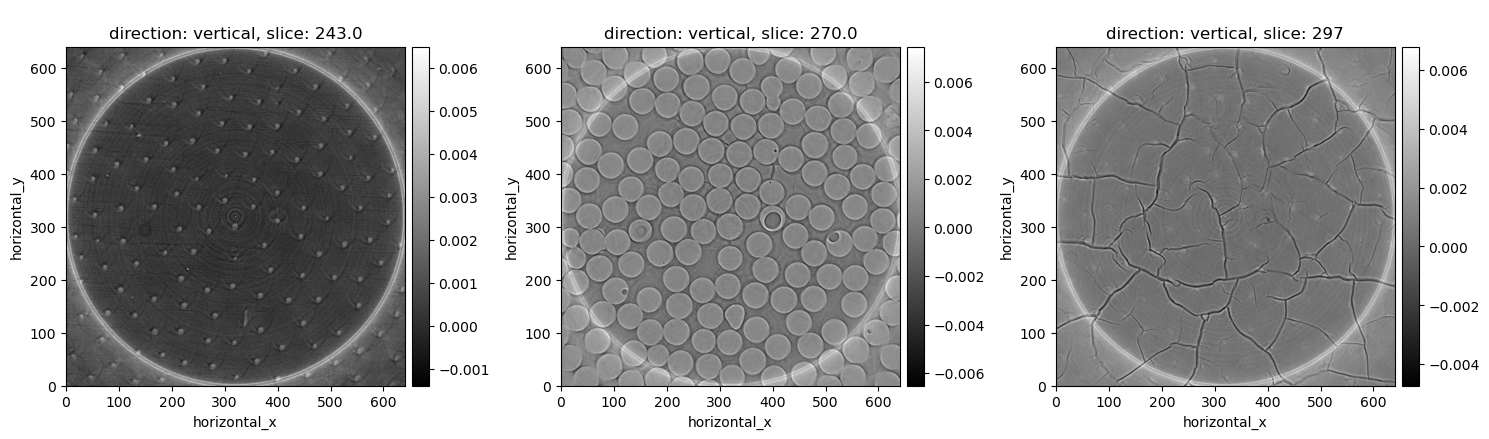

In [10]:
if optimise_geometry:
    ig_full = data_corrected.geometry.get_ImageGeometry()
    recon = FBP(ig_full, data_corrected.geometry)(data_corrected)
    slice_list = [('vertical',  int(ig_full.voxel_num_z)*0.45), ('vertical', int(ig_full.voxel_num_z)*0.5), ('vertical', int(ig_full.voxel_num_z*0.55))]
    show2D(recon, slice_list=slice_list, num_cols=3)

In [ ]:
from pathlib import Path
fp = Path(file_path)
recon_dir = fp.with_name(fp.stem + '_recon')
recon_dir.mkdir(parents=True, exist_ok=True)

TIFFWriter(recon, os.path.join(recon_dir, fp.stem + '_recon')).write()